<a href="https://colab.research.google.com/github/sanamaqqbool/breast-cancer-dagnosis/blob/main/downupnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classes: ['b', 'm', 'n']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 99.6MB/s]


Epoch 1/30 | Loss: 21.9002 | Accuracy: 0.7615
Epoch 2/30 | Loss: 11.9258 | Accuracy: 0.8859
Epoch 3/30 | Loss: 8.6245 | Accuracy: 0.9176
Epoch 4/30 | Loss: 6.7918 | Accuracy: 0.9414
Epoch 5/30 | Loss: 4.8165 | Accuracy: 0.9572
Epoch 6/30 | Loss: 4.4377 | Accuracy: 0.9628
Epoch 7/30 | Loss: 3.8500 | Accuracy: 0.9707
Epoch 8/30 | Loss: 4.7392 | Accuracy: 0.9604
Epoch 9/30 | Loss: 3.4125 | Accuracy: 0.9739
Epoch 10/30 | Loss: 2.4406 | Accuracy: 0.9794
Epoch 11/30 | Loss: 2.7036 | Accuracy: 0.9818
Epoch 12/30 | Loss: 3.0802 | Accuracy: 0.9754
Epoch 13/30 | Loss: 2.7843 | Accuracy: 0.9794
Epoch 14/30 | Loss: 2.5514 | Accuracy: 0.9746
Epoch 15/30 | Loss: 2.2848 | Accuracy: 0.9802
Epoch 16/30 | Loss: 1.3542 | Accuracy: 0.9865
Epoch 17/30 | Loss: 1.1021 | Accuracy: 0.9873
Epoch 18/30 | Loss: 0.8379 | Accuracy: 0.9921
Epoch 19/30 | Loss: 0.8808 | Accuracy: 0.9889
Epoch 20/30 | Loss: 0.6840 | Accuracy: 0.9921
Epoch 21/30 | Loss: 0.9795 | Accuracy: 0.9929
Epoch 22/30 | Loss: 0.7957 | Accuracy: 0.

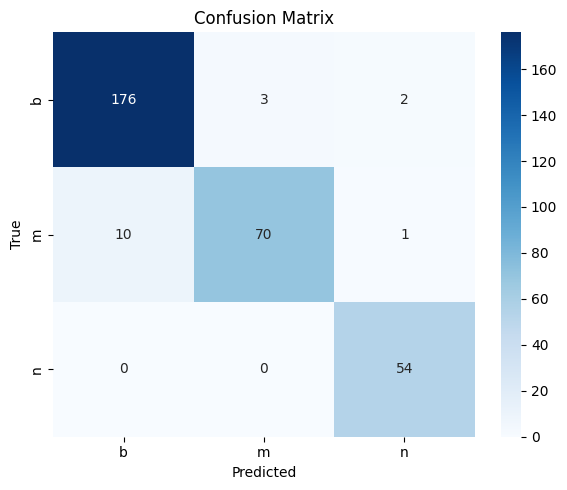

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# 📦 Import packages
import os, shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files

# ✅ Clean up any .ipynb_checkpoints
data_dir = "/content/content breast cancer"  # UPDATE IF NEEDED
for root, dirs, _ in os.walk(data_dir):
    for d in dirs:
        if d == ".ipynb_checkpoints":
            shutil.rmtree(os.path.join(root, d))

# ✅ Transforms with augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Load Dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)

# ✅ Split into train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# ✅ Define DownUpNet (Modified DenseNet201)
class DownUpNet(nn.Module):
    def __init__(self, num_classes=3):
        super(DownUpNet, self).__init__()

        # Base: DenseNet201
        base = models.densenet201(pretrained=True)
        self.features = base.features

        # Custom layer: makes it "202 layers"
        self.extra_conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(1920, 1920, kernel_size=1),  # Adds 1 more layer
            nn.BatchNorm2d(1920),
            nn.ReLU()
        )

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1920, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.extra_conv(x)
        x = self.classifier(x)
        return x

# ✅ Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DownUpNet(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3)

# ✅ Training Loop
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {acc:.4f}")
    scheduler.step(acc)

# ✅ Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ✅ Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ✅ Confusion Matrix (Downloadable)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
save_path = "downupnet_confusion_matrix.png"
plt.savefig(save_path)
plt.show()
files.download(save_path)


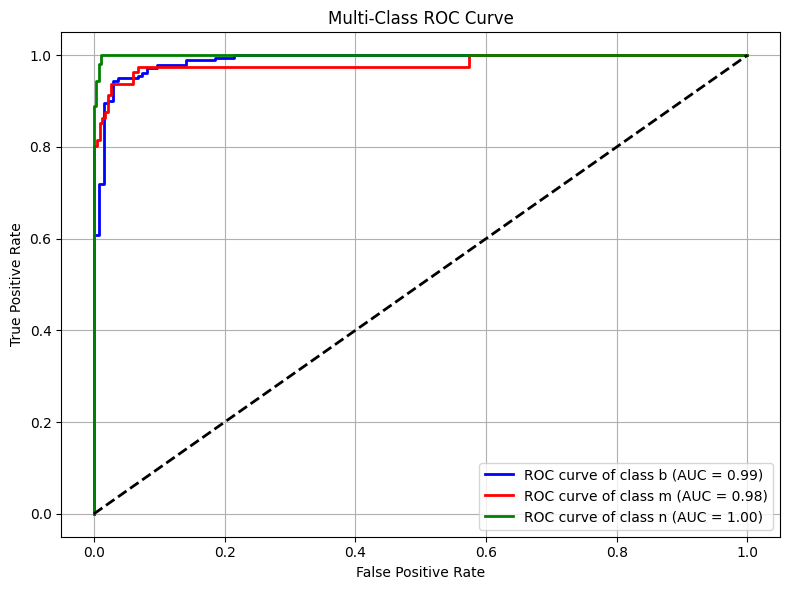

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ✅ Binarize the output
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
n_classes = y_true_bin.shape[1]

# Get model probabilities
y_score = []
model.eval()
with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        y_score.extend(probs.cpu().numpy())
y_score = np.array(y_score)

# ✅ Compute ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ✅ Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()
files.download("roc_curve.png")


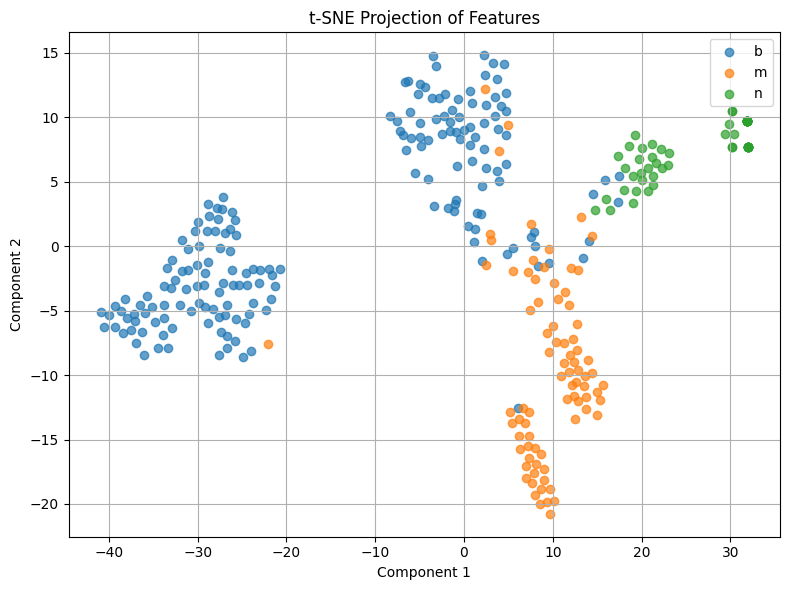

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
from sklearn.manifold import TSNE

# ✅ Get features from penultimate layer
feature_extractor = nn.Sequential(model.features, model.extra_conv, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten()).to(device)
features, labels = [], []

model.eval()
with torch.no_grad():
    for images, lbls in val_loader:
        images = images.to(device)
        feats = feature_extractor(images)
        features.extend(feats.cpu().numpy())
        labels.extend(lbls.cpu().numpy())

# ✅ Run t-SNE
features_np = np.array(features)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features_np)

# ✅ Plot t-SNE
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    idxs = np.where(np.array(labels) == i)
    plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], label=class_name, alpha=0.7)

plt.legend()
plt.title('t-SNE Projection of Features')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("tsne_features.png")
plt.show()
files.download("tsne_features.png")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
